<bold><font size="6">Transfer Learning Tremor Location (TL): Tutorial</font></bold>
# Introduction

In this jupyter notebook we show how to use the `tl` package. Let's import this package and other dependencies used in this tutorial:

In [1]:
import warnings

import pandas as pd

from obspy.clients.fdsn.client import Client
from obspy import UTCDateTime
from obspy.clients.fdsn.mass_downloader import (
    CircularDomain, Restrictions, MassDownloader
)

import tl


warnings.filterwarnings('ignore')

Our study case is the tremor from the Kilauea summit caldera collapse in 2018. For the sake of technical illustration, we use a minimal working example. The results are not satisfying since the training and prediction data sets are very small. Nonetheless, this example can be modified to run with the full dataset and reproduce the results presented in van der Laat et al. (2023).

## yaml configuration file

This file contains all the user-defined parameters that you can modify. We will use the `config.yml` file in this folder. You can have it open in a text editor, we will modify it along the way.

## Command-line programs

For every main step in this analysis we use command-line programs. If you were in your console and the installation of this package was succesful, you would be able to run it using a command like the following:

    $ tl-[PROGRAM] config.yml

Since we are in a jupyter notebook we will be appending a `!` in front or using this type of command:

    %run ../bin/tl-[PROGRAM] config.yml
    
Each of this programs will create a folder for output. If you are running different configurations, you can choose to overwrite the folder or to avoid that. I/O is controlled in the configuration file in the `io` section. Keep a file explorer open during this tutorial so you can see the changes in the directory.

For each program a different set of parameters in the configuration file is used. To know which parameters are being used in a particular program run this command line:

    $ tl-help [PROGRAM]
    
For example:

In [2]:
!tl-help feature-extraction-tremor

============== Transfer Learning Tremor Location: Parameters Used ==============

 ====================== Program: feature-extraction-tremor ======================
-------------------------------------- io --------------------------------------
	 output_dir
	 overwrite
---------------------------------- preprocess ----------------------------------
	 inventory
	 freqmin
	 freqmax
	 decimation_factor
----------------------------------- features -----------------------------------
	 channels_csv
	 bands
	 order
	 datatype
----------------------------------- dataset ------------------------------------
	 wfs_dir
--------------------------------- performance ----------------------------------
	 max_workers
------------------------------------ tremor ------------------------------------
	 wfs_dir
	 window_length
	 overlap
	 startdate
	 enddate


The options for `tl-help` can be printed by using this command:

In [3]:
!tl-help -h

usage: tl-help [-h]
               {synth,get-wfs-eq,feature-extraction-eq,feature-extraction-tremor,train,predict}

positional arguments:
  {synth,get-wfs-eq,feature-extraction-eq,feature-extraction-tremor,train,predict}
                        name of the program

options:
  -h, --help            show this help message and exit


For the sake of clarity and brevity we won't be discussing each of the parameters, 
but you are welcome to run `tl-help` at anytime so you can have in mind which parameters are needed in any step.

# Set-up the experiment

## Cartesian projection

The `tl` package works with cartesian coordinates. [Find out your EPSG code](https://epsg.io/). For this example, we use the [NAD83 / Hawaii zone 1](https://epsg.io/26961) projection with the code `26961`. In the configuration file

```yaml
projection:
    epsg: 26961
```

## Seismic stations
### `STATIONXML` response file

Let's first obtain our inventory from the IRIS-DMC for the area and time range that we desire and write it to a file for later use:

In [14]:
client = Client('IRIS')

inventory = client.get_stations(
    starttime=UTCDateTime(2018, 1, 1),
    endtime=UTCDateTime(2019, 1, 1),
    network='HV',
    channel='EH*,HH*',
    minlatitude=19.3270,
    maxlatitude=19.4704,
    minlongitude=-155.3339,
    maxlongitude=-155.1631,
    level='channel'
)

inventory.write('inventory.xml', format='STATIONXML')

Annotate the path to this file in your configuration file:

```yaml
preprocess:
    inventory: inventory.xml
```

### Stations `CSV` file
For user easy network configuration we convert the STATIONXML file to a simple dataframe:

In [5]:
df = tl.inventory.to_dataframe(inventory)

In this case we won't some stations, we can filter them out:

In [6]:
df = df[~df.station.isin(['NAHU', 'NPT', 'HAT', 'KKO', 'OBL'])]

We also perform the transformation of the coordinate system:

In [7]:
df['x'], df['y'] = tl.projection.geographic_to_cartesian(
    df.longitude.values, df.latitude.values, 26961
)
df.reset_index(inplace=True)
df

,index,network,station,channel,longitude,latitude,z,x,y
0,0,HV,AHUD,EHE,-155.263462,19.371567,1051.0,524848.012953,59592.976092
1,1,HV,AHUD,EHN,-155.263462,19.371567,1051.0,524848.012953,59592.976092
2,2,HV,AHUD,EHZ,-155.263462,19.371567,1051.0,524848.012953,59592.976092
3,3,HV,BYL,HHE,-155.259872,19.412086,1079.0,525218.906428,64078.741166
4,4,HV,BYL,HHN,-155.259872,19.412086,1079.0,525218.906428,64078.741166
5,5,HV,BYL,HHZ,-155.259872,19.412086,1079.0,525218.906428,64078.741166
6,6,HV,CPKD,EHZ,-155.324317,19.391443,1038.0,518452.706814,61785.625287
7,7,HV,DEVL,HHE,-155.240608,19.373568,1046.0,527248.588901,59817.880035
8,8,HV,DEVL,HHN,-155.240608,19.373568,1046.0,527248.588901,59817.880035
9,9,HV,DEVL,HHZ,-155.240608,19.373568,1046.0,527248.588901,59817.880035


Let's write the dataframe to a `csv` file:

In [8]:
df.to_csv('channels.csv', index=False)

Annotate the path to this file in your configuration file:

```yaml
features:
    channels_csv: channels.csv
```

## Earthquake catalog

This package uses a catalog formatted as a `csv` file as following:

| time | latitude | longitude | depth | magnitude | eventid | x | y | z |
| ---- | -------- | --------- | ----- | --------- | ------- | - | - | - |
| 2018-04-29 01:24:11 | 19.40776 | -155.29421 | 1.265 | 0.64 | 42905052 | 521613 | 63595 | -1265 |

In this case we use the catalog genereted by [Shelly and Thelen (2019)](https://doi.org/10.1029/2019GL085636). We already downloaded and converted this catalog to the `catalog.csv` file in this directory. In this catalog the reference for the depth is the summit elevation (~1.2 km). We corrected to obtain a sea level reference and transformed the geographic coordinates to cartesian like we did for the stations.

Annotate the path to this file in your configuration file:

```yaml
dataset:
    catalog: catalog.csv
    magnitude_min: 1
    magnitude_max: 5
    n_events: 100
```
In this section of the configuration file you can control how the filter the catalog. In this example we use a small number of events.

# Synthetic tests
We run a synthetic test in order to have an idea of how well this dataset in combination with the network configuration can do for our purposes.

2022-08-29 17:59:45,755 - root - INFO - n=100, n(train)=70, n(test)=30
2022-08-29 17:59:45,762 - root - INFO - Test error: 7 m
2022-08-29 17:59:45,763 - root - INFO - Standard deviation (xyz): [ 5  5 21] m
2022-08-29 17:59:45,764 - root - INFO - Prediction interval (xyz): [11 10 42] m
2022-08-29 17:59:46,866 - root - INFO - Total error: 0 m
2022-08-29 17:59:46,867 - root - INFO - Standard deviation (xyz): [0 0 0] m
2022-08-29 17:59:46,867 - root - INFO - Prediction interval (xyz): [0 0 0] m


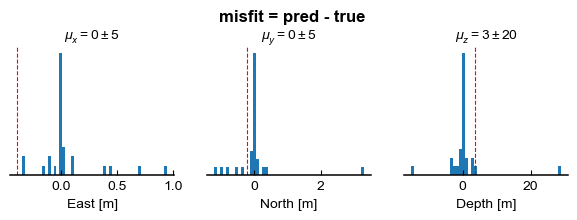

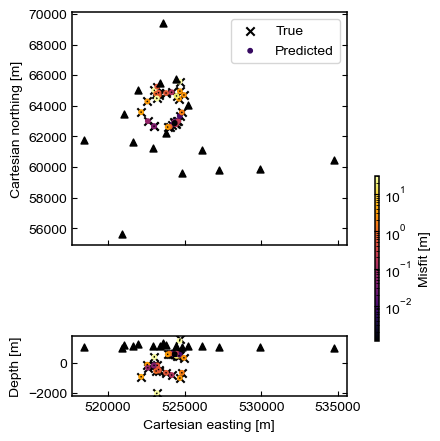

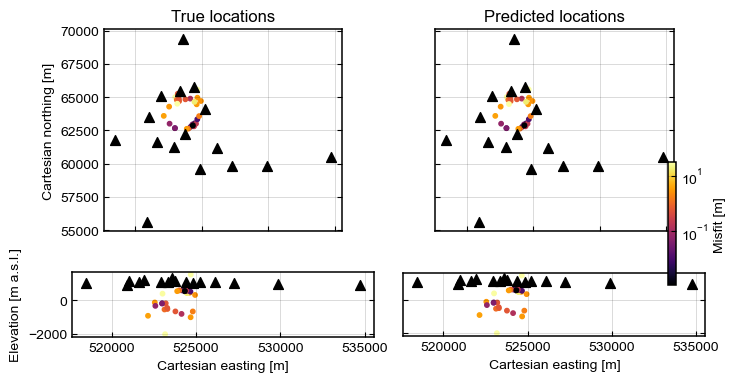

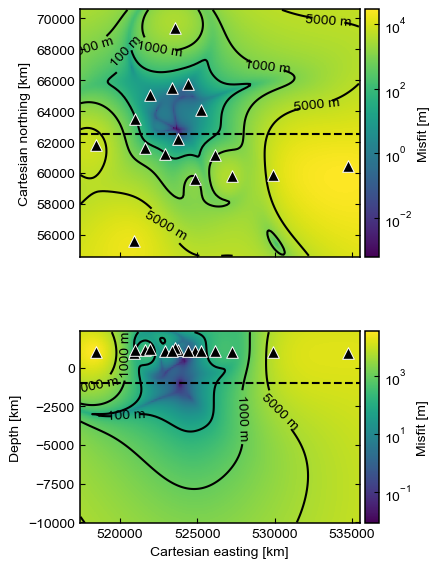

In [9]:
%run ../bin/tl-synth config.yml

# Learning from earthquakes: dataset and model training
## Download earthquake waveforms

We download one file per event in parallel, so in the configuration file you can limit the number of threads (4 is recommended, higher numbers of threads results in poor returns from the FDSN client).

```yaml
performance:
    max_workers: 4
```

Run the program:

In [10]:
!tl-get-wfs-eq config.yml

2022-08-29 18:00:00,438 - root - INFO - Downloading...
2022-08-29 18:01:03,106 - root - INFO - Done


You can scan the data you just download to count the number of events and stations/channel per event. The output can be used to clean the data afterwards.

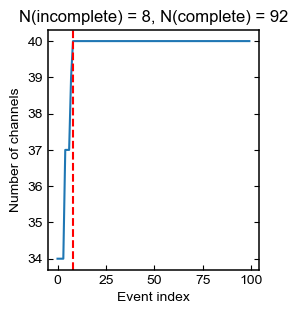

In [11]:
%run ../bin/tl-scan -i WFS_EQ/ -o .

This program outputs a folder `WFS_SCAN` and the plot above which shows the number of channels per event. 

There's three alternatives for dealing with incomplete data:
1. Moving the incomplete files to out of the folder (easy way, works fine if the incomplete files are just a few).
2. Keep the files; but drop the incomplete events when training (this is equivalent to 1., but gives you the possibility to consider option 3).
3. Keep the files; perform missing values imputation (this advanced option should be used if the missing values are too many).

For this example we will go with option 1. consider 40 channels, no more no less. We will clean the data using this cuttoff, by moving the incomplete files to another folder:

In [ ]:
%run ../bin/tl-clean -i WFS_EQ -o . -f WFS_SCAN/count_channels_per_event.csv -n 40

2022-08-29 18:01:13,937 - root - INFO - 8 incomplete files were moved out of the folder.
2022-08-29 18:01:13,937 - root - INFO - 8 incomplete files were moved out of the folder.
2022-08-29 18:01:13,937 - root - INFO - 8 incomplete files were moved out of the folder.
2022-08-29 18:01:13,939 - root - INFO - 92 files remain in the folder.
2022-08-29 18:01:13,939 - root - INFO - 92 files remain in the folder.
2022-08-29 18:01:13,939 - root - INFO - 92 files remain in the folder.


## Feature extraction of earthquakes data

To extract the features from the data we will be using the `tl-feature-extraction` program. This program requires a parameter that determine if you are processing earthquakes (pre-trimmed files) or tremor (continuous records). So you would add the argument `eq` or `tremor`.

2022-08-29 18:01:43,228 - root - INFO - Processing...
2022-08-29 18:01:43,228 - root - INFO - Processing...
2022-08-29 18:01:43,228 - root - INFO - Processing...
2022-08-29 18:01:43,228 - root - INFO - Processing...
2022-08-29 18:01:43,228 - root - INFO - Processing...
2022-08-29 18:01:43,228 - root - INFO - Processing...
2022-08-29 18:01:43,228 - root - INFO - Processing...


2022-08-29 18:01:46,301	INFO worker.py:1518 -- Started a local Ray instance.


2022-08-29 18:02:13,251 - root - INFO - Writing output...
2022-08-29 18:02:13,251 - root - INFO - Writing output...
2022-08-29 18:02:13,251 - root - INFO - Writing output...
2022-08-29 18:02:13,251 - root - INFO - Writing output...
2022-08-29 18:02:13,251 - root - INFO - Writing output...
2022-08-29 18:02:13,251 - root - INFO - Writing output...
2022-08-29 18:02:13,251 - root - INFO - Writing output...
2022-08-29 18:02:14,731 - root - INFO - Done.
2022-08-29 18:02:14,731 - root - INFO - Done.
2022-08-29 18:02:14,731 - root - INFO - Done.
2022-08-29 18:02:14,731 - root - INFO - Done.
2022-08-29 18:02:14,731 - root - INFO - Done.
2022-08-29 18:02:14,731 - root - INFO - Done.
2022-08-29 18:02:14,731 - root - INFO - Done.


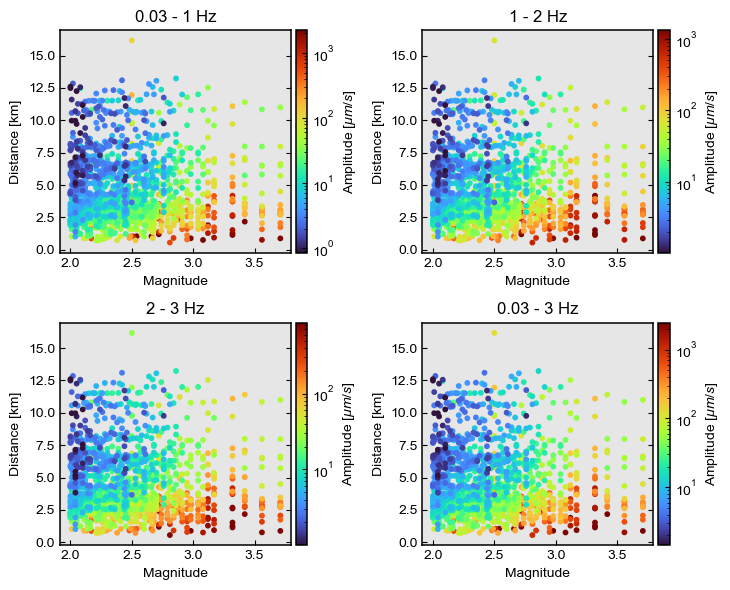

In [15]:
%run ../bin/tl-feature-extraction config.yml eq

## Training

2022-08-29 18:02:22,643 - root - INFO - Loading data...
2022-08-29 18:02:22,643 - root - INFO - Loading data...
2022-08-29 18:02:22,643 - root - INFO - Loading data...
2022-08-29 18:02:22,643 - root - INFO - Loading data...
2022-08-29 18:02:22,643 - root - INFO - Loading data...
2022-08-29 18:02:22,643 - root - INFO - Loading data...
2022-08-29 18:02:22,643 - root - INFO - Loading data...
2022-08-29 18:02:22,643 - root - INFO - Loading data...
2022-08-29 18:02:22,663 - root - INFO - Feature engeneering...
2022-08-29 18:02:22,663 - root - INFO - Feature engeneering...
2022-08-29 18:02:22,663 - root - INFO - Feature engeneering...
2022-08-29 18:02:22,663 - root - INFO - Feature engeneering...
2022-08-29 18:02:22,663 - root - INFO - Feature engeneering...
2022-08-29 18:02:22,663 - root - INFO - Feature engeneering...
2022-08-29 18:02:22,663 - root - INFO - Feature engeneering...
2022-08-29 18:02:22,663 - root - INFO - Feature engeneering...
2022-08-29 18:03:03,385 - root - INFO - 3120 fea

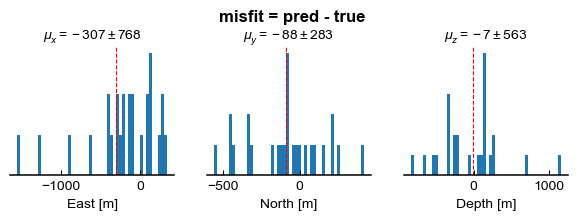

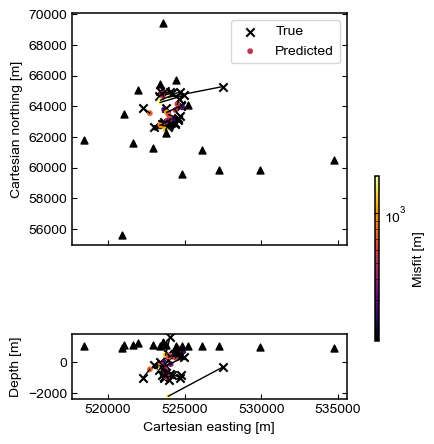

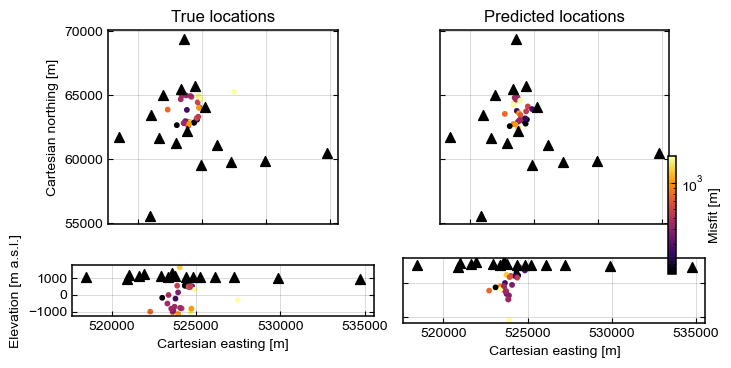

In [16]:
%run ../bin/tl-train config.yml

# Transfering learning to tremor: predicting locations
## Download waveforms

Use the following code to donwload continuous data for the day May 13, 2018.

In [17]:
df = pd.read_csv('channels.csv')

mdl = MassDownloader(providers=['IRIS'])

mdl.download(
    CircularDomain(
        latitude  = 19.410563,
        longitude = -155.276249,
        minradius = None,
        maxradius = 0.14
    ),
    Restrictions(
        starttime = UTCDateTime(2018, 5, 12),
        endtime   = UTCDateTime(2018, 5, 13),
        network   = 'HV',
        station   = ','.join(df.station.unique()),
        location  = '*',
        channel   = 'HH*,EH*',
        chunklength_in_sec = 86400,
        reject_channels_with_gaps = False,
        minimum_length = 0.0,
    ),
    threads_per_client = 10,
    mseed_storage = 'WFS_TR',
    stationxml_storage = 'stations'
)

[2022-08-29 18:03:28,844] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for IRIS.
[2022-08-29 18:03:28,970] - obspy.clients.fdsn.mass_downloader - INFO: Successfully initialized 1 client(s): IRIS.
[2022-08-29 18:03:28,974] - obspy.clients.fdsn.mass_downloader - INFO: Total acquired or preexisting stations: 0
[2022-08-29 18:03:28,975] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Requesting reliable availability.
[2022-08-29 18:03:29,529] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Successfully requested availability (0.55 seconds)
[2022-08-29 18:03:29,531] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Found 16 stations (40 channels).
[2022-08-29 18:03:29,533] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Will attempt to download data from 16 stations.
[2022-08-29 18:03:29,539] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Status for 40 time intervals/channels before downloading: NEED

{'IRIS': <obspy.clients.fdsn.mass_downloader.download_helpers.ClientDownloadHelper at 0x1aee99d80>}

Scan the files downloaded and check the figure in the output folder:

In [19]:
!obspy-scan WFS_TR -o WFS_TR_SCAN.pdf; open WFS_TR_SCAN.pdf

## Feature extraction

For extracting features in continuous we use the same program (`tl-feature_extraction`) with the `tremor` argument.

2022-08-29 18:15:45,262 - root - INFO - Processing...
2022-08-29 18:15:45,262 - root - INFO - Processing...
2022-08-29 18:15:45,262 - root - INFO - Processing...
2022-08-29 18:15:45,262 - root - INFO - Processing...
2022-08-29 18:15:45,262 - root - INFO - Processing...
2022-08-29 18:15:45,262 - root - INFO - Processing...
2022-08-29 18:15:45,262 - root - INFO - Processing...
2022-08-29 18:15:45,262 - root - INFO - Processing...
2022-08-29 18:15:45,262 - root - INFO - Processing...
2022-08-29 18:15:45,262 - root - INFO - Processing...
(PoolActor pid=13625) Loading files...
(PoolActor pid=13625) 2018-05-12T00:00:00.000000Z
(PoolActor pid=13625) Done
2022-08-29 18:16:15,858 - root - INFO - Done.
2022-08-29 18:16:15,858 - root - INFO - Done.
2022-08-29 18:16:15,858 - root - INFO - Done.
2022-08-29 18:16:15,858 - root - INFO - Done.
2022-08-29 18:16:15,858 - root - INFO - Done.
2022-08-29 18:16:15,858 - root - INFO - Done.
2022-08-29 18:16:15,858 - root - INFO - Done.
2022-08-29 18:16:15,85

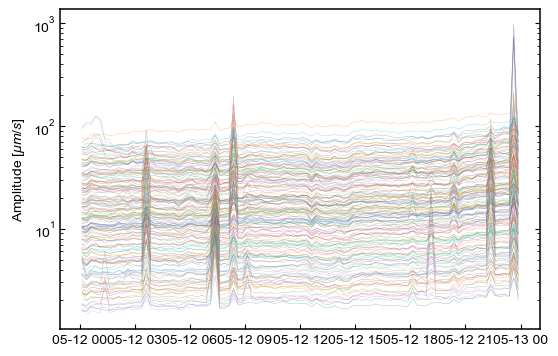

In [20]:
%run ../bin/tl-feature-extraction config.yml tremor

## Location prediction

Finally, we can obtain the locations of the tremor:

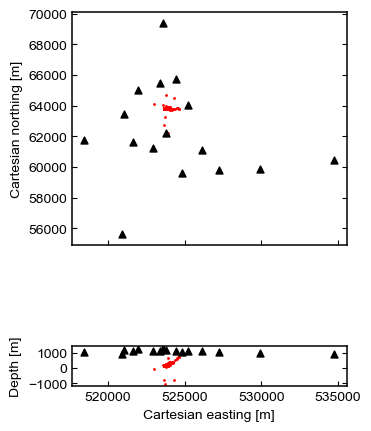

In [21]:
%run ../bin/tl-predict config.yml